In [1]:
'''
三分类语义分割
代码分为几段，段之间以空cell隔开

修改了：
1.削弱了数据增强的变动幅度，删去翻转的情况
2.将点云转体素时的标签分配方法改为投票法
3.重新选择损失函数，取Focal、Tversky和自己编写的Boundary
4.在可视化部分增加了用插值和CRF增加分辨率的方法

在原理上，边缘检测可以使用几乎相同的模型，这意味着：
1.语义分割中也可以加入边缘标签
2.只保留边缘标签时数据更稀疏，或许适用更高分辨率的体素网格
'''

'\n三分类语义分割\n代码分为几段，段之间以空cell隔开\n\n修改了：\n1.削弱了数据增强的变动幅度，删去翻转的情况\n2.将点云转体素时的标签分配方法改为投票法\n3.重新选择损失函数，取Focal、Tversky和自己编写的Boundary\n4.在可视化部分增加了用插值和CRF增加分辨率的方法\n\n在原理上，边缘检测可以使用几乎相同的模型，这意味着：\n1.语义分割中也可以加入边缘标签\n2.只保留边缘标签时数据更稀疏，或许适用更高分辨率的体素网格\n'

In [3]:
'''
统一设置地址
'''

import os

# 获取当前工作目录
current_dir = os.getcwd()
print("当前工作目录：", current_dir)

# 修改当前工作目录，以后输出文件只需要写文件名
new_dir = "D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/A_轮廓线识别/重新处理后的数据_手工筛选_0727/"
os.chdir(new_dir)
print("修改后的工作目录：", os.getcwd())


当前工作目录： C:\Users\51625\a-轮廓线识别
修改后的工作目录： D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\重新处理后的数据_手工筛选_0727


In [3]:
'''
训练UNET
'''

'\n训练UNET\n'

In [4]:
'''
加载并处理数据
非常慢，建议每次加载并处理后先行保存
'''

import numpy as np
from scipy.ndimage import rotate
from scipy.stats import mode
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# 读取点云数据和标签
def load_labeled_point_cloud(file_path):
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 4:
                x, y, z, label = map(float, parts)
                data.append([x, y, z])
                labels.append(int(label))
    return np.array(data), np.array(labels)

# 创建带标签的体素网格
def create_labeled_voxel_grid(data, labels, grid_size):
    if data.size == 0 or labels.size == 0:
        print(f"Warning: Empty data or labels array. data.size={data.size}, labels.size={labels.size}")
        return None, None

    grid = np.zeros((grid_size, grid_size, grid_size))
    label_grid = np.zeros((grid_size, grid_size, grid_size), dtype=int)  # Initialize with 0 to indicate empty space

    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    voxel_label_dict = {}

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        voxel_key = tuple(voxel)
        
        if voxel_key not in voxel_label_dict:
            voxel_label_dict[voxel_key] = []
        voxel_label_dict[voxel_key].append(labels[i])

    for voxel_key, label_list in voxel_label_dict.items():
        # 计算众数
        mode_result = mode(label_list)
        
        # 获取众数标签
        most_common_label = mode_result.mode  # mode_result.mode 是一个标量
        
        grid[voxel_key] = 1
        label_grid[voxel_key] = most_common_label

    return grid, label_grid

# 数据增强，对体素网格进行随机三轴小幅旋转
def augment_voxel_grid(voxel_grid):
    # 随机旋转角度（-10到10度）
    angles = np.random.uniform(-10, 10, size=3)
    
    # 对每个轴进行旋转
    voxel_grid = rotate(voxel_grid, angle=angles[0], axes=(1, 0), reshape=False, order=1, mode='nearest')
    voxel_grid = rotate(voxel_grid, angle=angles[1], axes=(2, 0), reshape=False, order=1, mode='nearest')
    voxel_grid = rotate(voxel_grid, angle=angles[2], axes=(2, 1), reshape=False, order=1, mode='nearest')
    
    return voxel_grid


# 从文件夹中读取数据并加工成体素网格
def load_data_from_directory(data_dir, grid_size=16):
    x_data = []
    y_data = []
    for file in os.listdir(data_dir):
        if file.endswith("_labeled.txt"):
            file_path = os.path.join(data_dir, file)
            data, labels = load_labeled_point_cloud(file_path)
            if data.size == 0 or labels.size == 0:
                print(f"Skipping empty file: {file_path}")
                continue
            voxel_grid, label_grid = create_labeled_voxel_grid(data, labels, grid_size)
            if voxel_grid is not None and label_grid is not None:
                # 关闭数据增强
                # voxel_grid = augment_voxel_grid(voxel_grid)
                x_data.append(voxel_grid)
                y_data.append(label_grid)
    x_data = np.expand_dims(np.array(x_data), axis=-1)
    y_data = np.expand_dims(np.array(y_data), axis=-1)
    return x_data, y_data


# 加载数据
data_dir = '重新处理后的数据_手工筛选'
x_data, y_data = load_data_from_directory(data_dir, grid_size=16)

# 确保数据归一化
x_data = x_data / np.max(x_data)

# 确保标签是0, 1, 2
y_data = y_data.astype(np.int32)

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)


In [5]:
# 保存加载好的数据备用
def save_processed_data(x_data, y_data, folder_path, file_prefix):

    # 确保文件夹存在
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # 保存数据到指定文件夹
    np.save(os.path.join(folder_path, f'{file_prefix}_x_data.npy'), x_data)
    np.save(os.path.join(folder_path, f'{file_prefix}_y_data.npy'), y_data)

data_folder_path = 'July31语义分割模型'
data_file_prefix = 'July31语义分割数据'
save_processed_data(x_data, y_data, data_folder_path, data_file_prefix)

In [2]:
'''
重新加载已保存的处理好的数据
如果已有数据则跳过此cell
'''

import numpy as np
from scipy.ndimage import rotate
from scipy.stats import mode
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_processed_data(folder_path, file_prefix):
    x_data = np.load(os.path.join(folder_path, f'{file_prefix}_x_data.npy'))
    y_data = np.load(os.path.join(folder_path, f'{file_prefix}_y_data.npy'))
    return x_data, y_data

# 加载保存的数据
data_folder_path = 'July31语义分割模型'
data_file_prefix = 'July31语义分割数据'
x_data, y_data = load_processed_data(data_folder_path, data_file_prefix)


# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)



In [3]:
# 绘制训练过程中的损失和精确度
def plot_training_history(history):
    """
    绘制训练过程中的损失和精确度。
    """
    # 绘制损失
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # 绘制精确度
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [4]:
# 定义UNET模型
def unet_3d(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv1)
    pool1 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool1)
    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv2)
    pool2 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool2)
    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv3)
    pool3 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Bottleneck
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool3)
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv4)

    # Decoder
    up5 = tf.keras.layers.Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(conv4)
    concat5 = tf.keras.layers.concatenate([up5, conv3], axis=-1)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat5)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv5)

    up6 = tf.keras.layers.Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(conv5)
    concat6 = tf.keras.layers.concatenate([up6, conv2], axis=-1)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat6)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv6)

    up7 = tf.keras.layers.Conv3DTranspose(64, 2, strides=(2, 2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv1], axis=-1)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat7)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv7)

    # 修改输出层，适应3个类别
    outputs = tf.keras.layers.Conv3D(3, 1, activation='softmax')(conv7)  # 3 channels for three-class classification

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [5]:
'''
定义各种损失函数
'''

import tensorflow.keras.backend as K
import numpy as np
import tensorflow as tf
from scipy.spatial.distance import cdist


# 交叉熵
def cross_entropy_loss(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True))

# Dice
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3, 4])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3, 4]) + tf.reduce_sum(y_pred, axis=[1, 2, 3, 4])
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return tf.reduce_mean(1 - dice)

# Focal
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # 确保 y_true 和 y_pred 都是 float32 类型
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        # 计算交叉熵
        cross_entropy = -y_true * tf.math.log(y_pred)
        # 计算 focal 权重
        focal_weight = alpha * tf.math.pow(1 - y_pred, gamma)
        # 计算 focal loss
        loss = focal_weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return focal_loss_fixed


# Tversky
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3, 4])
    false_neg = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2, 3, 4])
    false_pos = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3, 4])
    
    tversky = (intersection + smooth) / (intersection + alpha * false_neg + beta * false_pos + smooth)
    
    return tf.reduce_mean(1 - tversky)


# 组合损失函数
@tf.function
def combined_loss(y_true, y_pred):
    ce_loss = cross_entropy_loss(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    tversky = tversky_loss(y_true, y_pred)
    focal = focal_loss(gamma=2.0, alpha=0.25)(y_true, y_pred)
    
    return ce_loss + dice + tversky + focal



'''
'''
# 使用 TensorFlow 实现 Sobel 边缘检测
'''
def sobel_filter_3d():
    # 创建 Sobel 滤波器，注意这里设置 input_depth 为 1
    filters = {
        'x': tf.constant([[[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]],
                           [[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]],
                           [[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]]], dtype=tf.float32),
        'y': tf.constant([[[[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]],
                           [[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]],
                           [[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]]]], dtype=tf.float32),
        'z': tf.constant([[[[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]],
                           [[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]],
                           [[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]]]], dtype=tf.float32)
    }
    
    # 过滤器的形状应该为 (depth, height, width, in_channels, out_channels)
    filters['x'] = tf.reshape(filters['x'], [3, 3, 3, 1, 1])
    filters['y'] = tf.reshape(filters['y'], [3, 3, 3, 1, 1])
    filters['z'] = tf.reshape(filters['z'], [3, 3, 3, 1, 1])

    return filters

def apply_sobel_filters(volume, filters):
    volume = tf.expand_dims(volume, axis=-1)  # Ensure volume has channel dimension
    
    conv_x = tf.nn.conv3d(volume, filters['x'], strides=[1, 1, 1, 1, 1], padding='SAME')
    conv_y = tf.nn.conv3d(volume, filters['y'], strides=[1, 1, 1, 1, 1], padding='SAME')
    conv_z = tf.nn.conv3d(volume, filters['z'], strides=[1, 1, 1, 1, 1], padding='SAME')

    edges = tf.sqrt(tf.square(conv_x) + tf.square(conv_y) + tf.square(conv_z))
    return edges

def compute_sobel_edges_3d(volume):
    filters = sobel_filter_3d()
    edges = apply_sobel_filters(volume, filters)
    return edges



'''
# Boundary Loss
'''
# 欧几里得边界损失函数
@tf.function
def euclidean_distance_loss(true_edges, pred_edges):
    distance = tf.sqrt(tf.reduce_sum(tf.square(true_edges - pred_edges), axis=[1, 2, 3, 4]))
    return tf.reduce_mean(distance)

# 二进制交集边界损失函数
@tf.function
def binary_intersection_loss(true_edges, pred_edges):
    intersection = tf.reduce_sum(tf.cast(true_edges > 0, tf.float32) * tf.cast(pred_edges > 0, tf.float32), axis=[1, 2, 3, 4])
    return tf.reduce_mean(1 - intersection)


# 组合损失函数
@tf.function
def combined_loss(y_true, y_pred):
    
    # 确保 y_true 和 y_pred 是浮点型
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # 使用掩码来只关注标签1和标签2
    true_mask = tf.logical_or(tf.equal(y_true, 1), tf.equal(y_true, 2))
    pred_mask = tf.logical_or(tf.equal(y_pred, 1), tf.equal(y_pred, 2))
    
    # 将掩码应用于标签网格和预测网格
    y_true_masked = tf.where(true_mask, y_true, tf.zeros_like(y_true))
    y_pred_masked = tf.where(pred_mask, y_pred, tf.zeros_like(y_pred))
    
    # 计算真实边界和预测边界
    true_edges = compute_sobel_edges_3d(y_true_masked)
    pred_edges = compute_sobel_edges_3d(y_pred_masked)
    
    # 计算边界损失
    boundary_loss_euclidean = euclidean_distance_loss(true_edges, pred_edges)
    boundary_loss_intersection = binary_intersection_loss(true_edges, pred_edges)
    
    # 定义损失函数
    focal_loss_func = focal_loss(gamma=2.0, alpha=0.25)  # Create focal loss function
    focal = focal_loss_func(y_true, y_pred)  # Compute focal loss
    tversky = tversky_loss(y_true, y_pred)
    
    # 为每个损失函数赋权
    weight_focal = 1.5
    weight_tversky = 1.0
    weight_euclidean = 0.002
    weight_intersection = 1.0
    
    # 求和
    total_loss = (weight_focal * focal + 
                  weight_tversky * tversky + 
                  weight_euclidean * boundary_loss_euclidean +
                  weight_intersection * boundary_loss_intersection)
    
    return total_loss
'''

'\n# 欧几里得边界损失函数\n@tf.function\ndef euclidean_distance_loss(true_edges, pred_edges):\n    distance = tf.sqrt(tf.reduce_sum(tf.square(true_edges - pred_edges), axis=[1, 2, 3, 4]))\n    return tf.reduce_mean(distance)\n\n# 二进制交集边界损失函数\n@tf.function\ndef binary_intersection_loss(true_edges, pred_edges):\n    intersection = tf.reduce_sum(tf.cast(true_edges > 0, tf.float32) * tf.cast(pred_edges > 0, tf.float32), axis=[1, 2, 3, 4])\n    return tf.reduce_mean(1 - intersection)\n\n\n# 组合损失函数\n@tf.function\ndef combined_loss(y_true, y_pred):\n    \n    # 确保 y_true 和 y_pred 是浮点型\n    y_true = tf.cast(y_true, tf.float32)\n    y_pred = tf.cast(y_pred, tf.float32)\n    \n    # 使用掩码来只关注标签1和标签2\n    true_mask = tf.logical_or(tf.equal(y_true, 1), tf.equal(y_true, 2))\n    pred_mask = tf.logical_or(tf.equal(y_pred, 1), tf.equal(y_pred, 2))\n    \n    # 将掩码应用于标签网格和预测网格\n    y_true_masked = tf.where(true_mask, y_true, tf.zeros_like(y_true))\n    y_pred_masked = tf.where(pred_mask, y_pred, tf.zeros_like(y_

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.7240 - loss: 2.5849 - val_accuracy: 0.7568 - val_loss: 2.4244 - learning_rate: 3.0000e-05
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.7945 - loss: 2.3500 - val_accuracy: 0.9037 - val_loss: 2.1876 - learning_rate: 3.0000e-05
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9117 - loss: 2.1746 - val_accuracy: 0.9307 - val_loss: 2.1440 - learning_rate: 3.0000e-05
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9345 - loss: 2.1388 - val_accuracy: 0.9346 - val_loss: 2.1183 - learning_rate: 3.0000e-05
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9446 - loss: 2.1134 - val_accuracy: 0.9569 - val_loss: 2.0980 - learning_rate: 3.0000e-05
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9546 - loss: 2.0946 - val_accuracy: 0.9570 - val_loss: 2.0834 - learning_rate: 2.7145e-05
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.9603 

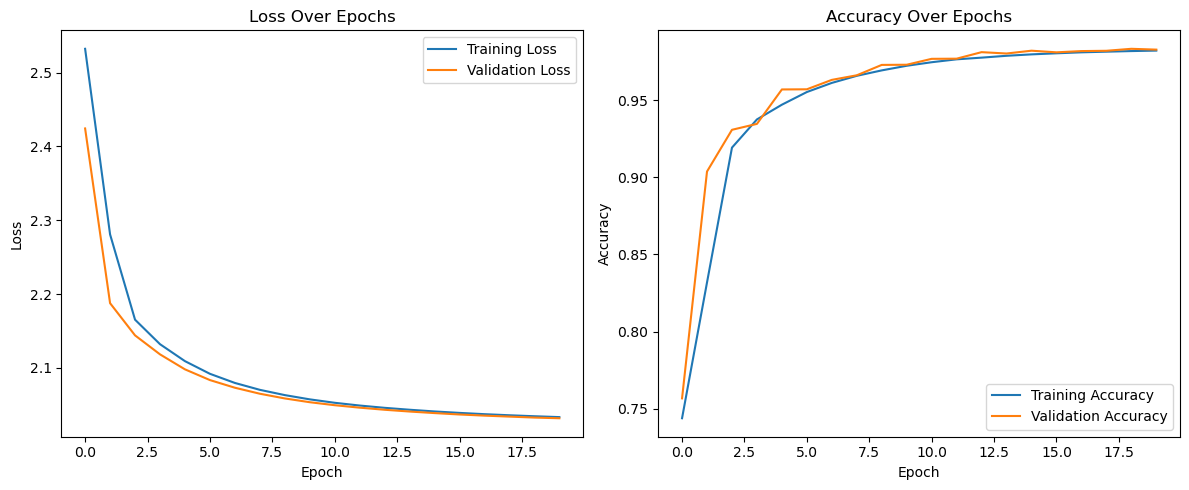

Model saved to July31语义分割模型/UNET.h5


In [6]:
# 定义模型
input_shape = (16, 16, 16, 1)
model = unet_3d(input_shape)

# 定义学习率调度函数
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1).numpy())

# 定义学习率调度回调和早停回调
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003), 
              loss=combined_loss,
              metrics=['accuracy'])

# 训练模型
history = model.fit(
    x_train, y_train, 
    validation_split=0.1,
    epochs=20, 
    batch_size=10,
    callbacks=[lr_scheduler, early_stopping]
)

# 评估模型
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 显示炼丹过程
plot_training_history(history)

# 保存模型
model_save_path = 'July31语义分割模型/UNET.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


In [ ]:
'''
预测及可视化
基于拓扑图绘制1-2区域分界线
'''

In [7]:
# 加载模型，如果已经有模型可以不运行这个cell
model_load_path = 'July31语义分割模型/UNET.h5'

# 自定义损失函数字典
custom_objects = {
    'cross_entropy_loss': cross_entropy_loss,
    'dice_loss': dice_loss,
    'focal_loss': focal_loss,
    'tversky_loss': tversky_loss,
    'combined_loss': combined_loss
}

try:
    model = tf.keras.models.load_model(model_load_path, custom_objects=custom_objects)
    print("模型加载成功！")
except Exception as e:
    print("模型加载失败:", e)

模型加载成功！


In [9]:
# 开启交互旋转
%matplotlib notebook


In [11]:
'''
读取点云并对预测每点的类别标签
'''

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations

def load_obj_file(file_path):
    vertices = []
    faces = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):
                vertices.append(list(map(float, line.strip().split()[1:])))
            elif line.startswith('f '):
                faces.append([int(idx.split('/')[0]) - 1 for idx in line.strip().split()[1:]])
    return np.array(vertices), np.array(faces)

def center_vertices(vertices):
    centroid = np.mean(vertices, axis=0)
    return vertices - centroid

def create_voxel_grid(points, grid_size):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size
    
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.int32)
    for point in points:
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        voxel_grid[voxel[0], voxel[1], voxel[2]] += 1
    
    return voxel_grid, min_coords, voxel_dim

def get_labels_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    
    labels = np.argmax(predictions, axis=-1)  # Get the class with the highest probability
    labels = labels.reshape(voxel_grid.shape[1], voxel_grid.shape[2], voxel_grid.shape[3])
    
    return labels

def apply_labels_to_point_cloud(data, predicted_labels, min_coords, voxel_dim, grid_size):
    labels = np.zeros(len(data))
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        labels[i] = predicted_labels[voxel[0], voxel[1], voxel[2]]
    return labels


In [13]:
'''
给点云画拓扑图
'''

import numpy as np
import networkx as nx
from sklearn.neighbors import NearestNeighbors

def build_topology_graph(vertices, k=10):
    # 计算k近邻图
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(vertices)
    distances, indices = nbrs.kneighbors(vertices)
    
    G = nx.Graph()
    for i, neighbors in enumerate(indices):
        for j in neighbors:
            if i != j:
                G.add_edge(i, j)
                
    return G

def largest_connected_component(G, nodes):
    subgraph = G.subgraph(nodes)
    largest_cc = max(nx.connected_components(subgraph), key=len)
    return subgraph.subgraph(largest_cc)

def get_max_connected_subgraphs(G, labels, target_labels):
    subgraphs = {}
    for label in target_labels:
        nodes = [i for i, l in enumerate(labels) if l == label]
        if nodes:
            largest_cc = largest_connected_component(G, nodes)
            subgraphs[label] = largest_cc
    return subgraphs



In [15]:
'''
找1-2的边界线
'''

def find_boundary_edges(G, subgraph1, subgraph2):
    boundary_edges = []
    for edge in G.edges():
        if (edge[0] in subgraph1 and edge[1] in subgraph2) or (edge[0] in subgraph2 and edge[1] in subgraph1):
            boundary_edges.append(edge)
    return boundary_edges

def plot_surface_with_boundary_lines(vertices, faces, labels, boundary_edges, view_angles=(30, 30), angles=(0, 0, 0)):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d.art3d import Line3DCollection

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    vertices = np.array(vertices)
    faces = np.array(faces)
    
    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T
    
    # 绘制不同标签区域的点云
    colors = ['lightgreen', 'cornflowerblue', 'honeydew']
    for i in range(3):
        part_faces = [face for face in faces if sum(labels[vertex] == i for vertex in face) > 1]
        if len(part_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part_faces, color=colors[i], alpha=0.6)
    
    # 绘制边界线
    for edge in boundary_edges:
        p1, p2 = vertices[list(edge)]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='red', lw=1)
    
    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Boundary Lines')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()


In [17]:
'''
设置视角
'''

def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T


In [19]:
'''
出图
'''

# 加载点云数据
obj_file_path = r'D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/A_轮廓线识别/重新处理后的数据_手工筛选_0727/肩台外侧点_0715/15/15_1.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, voxel_dim = create_voxel_grid(np.array(centered_vertices), grid_size)

# 使用训练好的模型进行预测
predicted_labels = get_labels_from_model(model, voxel_grid)

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels, min_coords, voxel_dim, grid_size)

# 构建拓扑图
G = build_topology_graph(centered_vertices)

# 找到最大连通子图
target_labels = [1, 2]
subgraphs = get_max_connected_subgraphs(G, predicted_point_labels, target_labels)

# 找到边界线
boundary_edges = find_boundary_edges(G, subgraphs[1], subgraphs[2])

# 绘制点云及边界线
plot_surface_with_boundary_lines(centered_vertices, faces, predicted_point_labels, boundary_edges, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


<IPython.core.display.Javascript object>

In [1]:
from IPython.display import Javascript, display

display(Javascript('alert("Hello, World!")'))


<IPython.core.display.Javascript object>

In [1]:
'''
改进可视化：
1.用线性插值生成更大体素网格
2.加入CRF
'''

'\n改进可视化：\n1.用线性插值生成更大体素网格\n2.加入CRF\n'

In [21]:
# 加载模型，如果已经有模型可以不运行这个cell
import tensorflow as tf

model_load_path = 'July31语义分割模型/UNET.h5'

# 自定义损失函数字典
custom_objects = {
    'cross_entropy_loss': cross_entropy_loss,
    'dice_loss': dice_loss,
    'focal_loss': focal_loss,
    'tversky_loss': tversky_loss,
    'combined_loss': combined_loss
}

try:
    model = tf.keras.models.load_model(model_load_path, custom_objects=custom_objects)
    print("模型加载成功！")
except Exception as e:
    print("模型加载失败:", e)

模型加载成功！


In [23]:
# 开启交互旋转
%matplotlib notebook


In [25]:
import sys
print(sys.executable)



E:\ananconda\python.exe


In [23]:
!pip install pydensecrf


Defaulting to user installation because normal site-packages is not writeable


In [27]:
import numpy as np
import tensorflow as tf
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import create_pairwise_gaussian, create_pairwise_bilateral, unary_from_softmax


def load_obj_file(file_path):
    vertices = []
    faces = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):
                vertices.append(list(map(float, line.strip().split()[1:])))
            elif line.startswith('f '):
                faces.append([int(idx.split('/')[0]) - 1 for idx in line.strip().split()[1:]])
    return np.array(vertices), np.array(faces)

def center_vertices(vertices):
    centroid = np.mean(vertices, axis=0)
    return vertices - centroid

def create_voxel_grid(points, grid_size):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size
    
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.int32)
    for point in points:
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        voxel_grid[voxel[0], voxel[1], voxel[2]] += 1
    
    return voxel_grid, min_coords, voxel_dim

def get_labels_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    
    labels = np.argmax(predictions, axis=-1)  # Get the class with the highest probability
    labels = labels.reshape(voxel_grid.shape[1], voxel_grid.shape[2], voxel_grid.shape[3])
    
    return labels

def upscale_voxel_grid(voxel_grid, new_grid_size):
    old_size = voxel_grid.shape[0]
    scale_factor = new_grid_size / old_size
    
    # Create an empty grid with new dimensions
    new_voxel_grid = np.zeros((new_grid_size, new_grid_size, new_grid_size), dtype=np.int32)
    
    # Use interpolation to fill the new grid
    for i in range(new_grid_size):
        for j in range(new_grid_size):
            for k in range(new_grid_size):
                # Compute the corresponding coordinates in the old grid
                old_i = int(i / scale_factor)
                old_j = int(j / scale_factor)
                old_k = int(k / scale_factor)
                
                # Use nearest neighbor interpolation for simplicity
                new_voxel_grid[i, j, k] = voxel_grid[old_i, old_j, old_k]
    
    return new_voxel_grid

def apply_crf(voxel_grid, probs):
    grid_size = voxel_grid.shape[0]
    num_voxels = grid_size * grid_size * grid_size

    # 创建 DenseCRF 对象
    d = dcrf.DenseCRF(num_voxels, 2)

    # 创建 Unary 能量
    probs = np.stack([1 - probs, probs], axis=0)  # Create the correct shape for probabilities
    probs = np.ascontiguousarray(probs)
    probs = probs.reshape((2, num_voxels))  # Reshape probabilities to (2, num_voxels)

    U = unary_from_softmax(probs)
    d.setUnaryEnergy(U)

    # 增加高斯对势能（基于位置的光滑项）
    pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3, 3), shape=(grid_size, grid_size, grid_size))
    d.addPairwiseEnergy(pairwise_gaussian, compat=3)

    # 增加双边对势能（基于颜色和位置的光滑项）
    voxel_grid = voxel_grid.reshape((grid_size, grid_size, grid_size, 1))  # Reshape voxel grid to add a channel dimension
    pairwise_bilateral = create_pairwise_bilateral(sdims=(3, 3, 3), schan=(1,), img=voxel_grid, chdim=3)
    d.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # 进行推理
    Q = d.inference(5)
    Q = np.array(Q)  # 将 Q 转换为 NumPy 数组

    # 获得分割结果
    result = np.argmax(Q, axis=0).reshape((grid_size, grid_size, grid_size))

    return result

def apply_labels_to_point_cloud(data, predicted_labels, min_coords, voxel_dim, grid_size):
    labels = np.zeros(len(data))
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        labels[i] = predicted_labels[voxel[0], voxel[1], voxel[2]]
    return labels


In [29]:
'''
给点云画拓扑图
'''

import numpy as np
import networkx as nx
from sklearn.neighbors import NearestNeighbors

def build_topology_graph(vertices, k=10):
    # 计算k近邻图
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(vertices)
    distances, indices = nbrs.kneighbors(vertices)
    
    G = nx.Graph()
    for i, neighbors in enumerate(indices):
        for j in neighbors:
            if i != j:
                G.add_edge(i, j)
                
    return G

def largest_connected_component(G, nodes):
    subgraph = G.subgraph(nodes)
    largest_cc = max(nx.connected_components(subgraph), key=len)
    return subgraph.subgraph(largest_cc)

def get_max_connected_subgraphs(G, labels, target_labels):
    subgraphs = {}
    for label in target_labels:
        nodes = [i for i, l in enumerate(labels) if l == label]
        if nodes:
            largest_cc = largest_connected_component(G, nodes)
            subgraphs[label] = largest_cc
    return subgraphs



In [31]:
'''
找1-2的边界线
'''

def find_boundary_edges(G, subgraph1, subgraph2):
    boundary_edges = []
    for edge in G.edges():
        if (edge[0] in subgraph1 and edge[1] in subgraph2) or (edge[0] in subgraph2 and edge[1] in subgraph1):
            boundary_edges.append(edge)
    return boundary_edges

def plot_surface_with_boundary_lines(vertices, faces, labels, boundary_edges, view_angles=(30, 30), angles=(0, 0, 0)):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d.art3d import Line3DCollection

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    vertices = np.array(vertices)
    faces = np.array(faces)
    
    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T
    
    # 绘制不同标签区域的点云
    colors = ['lightgreen', 'cornflowerblue', 'honeydew']
    for i in range(3):
        part_faces = [face for face in faces if sum(labels[vertex] == i for vertex in face) > 1]
        if len(part_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part_faces, color=colors[i], alpha=0.6)
    
    # 绘制边界线
    for edge in boundary_edges:
        p1, p2 = vertices[list(edge)]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='red', lw=1)
    
    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Boundary Lines')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()


In [33]:
'''
设置视角
'''

def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T


In [35]:
'''
出图
'''

# 加载点云数据
obj_file_path = r'D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/A_轮廓线识别/重新处理后的数据_手工筛选_0727/肩台外侧点_0715/15/15_1.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, voxel_dim = create_voxel_grid(np.array(centered_vertices), grid_size)

# 使用训练好的模型进行预测
predicted_labels = get_labels_from_model(model, voxel_grid)

# 等比扩大体素网格
new_grid_size = 128  # Example new grid size, adjust as needed
upscaled_voxel_grid = upscale_voxel_grid(voxel_grid, new_grid_size)

# 使用CRF后处理
probs = np.array(predicted_labels, dtype=np.float32) / np.max(predicted_labels)  # Normalize probabilities
predicted_labels_crf = apply_crf(upscaled_voxel_grid, probs)

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels_crf, min_coords, voxel_dim, new_grid_size)

# 构建拓扑图
G = build_topology_graph(centered_vertices)

# 找到最大连通子图
target_labels = [1, 2]
subgraphs = get_max_connected_subgraphs(G, predicted_point_labels, target_labels)

# 找到边界线
boundary_edges = find_boundary_edges(G, subgraphs[1], subgraphs[2])

# 绘制点云及边界线
plot_surface_with_boundary_lines(centered_vertices, faces, predicted_point_labels, boundary_edges, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


ValueError: cannot reshape array of size 8192 into shape (2,2097152)

In [53]:
pip install scipy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [43]:
import scipy


In [49]:
#修改以后的GRF
import networkx as nx

def build_topology_graph(vertices):
    G = nx.Graph()
    for i, vertex in enumerate(vertices):
        G.add_node(i, pos=vertex)
    return G

def get_max_connected_subgraphs(G, predicted_point_labels, target_labels):
    subgraphs = {}
    for label in target_labels:
        nodes = [i for i, lbl in enumerate(predicted_point_labels) if lbl == label]
        if nodes:
            subgraph = G.subgraph(nodes)
            largest_cc = max(nx.connected_components(subgraph), key=len)
            subgraphs[label] = G.subgraph(largest_cc).copy()
        else:
            subgraphs[label] = nx.Graph()  # 创建空图以避免 KeyError
    return subgraphs

def find_boundary_edges(G, subgraph1, subgraph2):
    boundary_edges = []
    for node1 in subgraph1.nodes:
        for neighbor in G.neighbors(node1):
            if neighbor in subgraph2:
                boundary_edges.append((node1, neighbor))
    return boundary_edges

# 示例代码继续
obj_file_path = r'D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/A_轮廓线识别/重新处理后的数据_手工筛选_0727/肩台外侧点_0715/15/15_1.obj'

# 定义 load_obj_file 函数示例
def load_obj_file(file_path):
    vertices = []
    faces = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):
                parts = line.strip().split()
                vertices.append([float(parts[1]), float(parts[2]), float(parts[3])])
            elif line.startswith('f '):
                parts = line.strip().split()
                face = [int(parts[i].split('/')[0]) - 1 for i in range(1, len(parts))]
                faces.append(face)
    return np.array(vertices), np.array(faces)

def center_vertices(vertices):
    if vertices is None or len(vertices) == 0:
        raise ValueError("输入的顶点数组为空。")
    
    # 将顶点中心化到原点
    center = np.mean(vertices, axis=0)
    centered_vertices = vertices - center
    
    return centered_vertices

def create_voxel_grid(vertices, grid_size):
    if vertices is None or len(vertices) == 0:
        raise ValueError("输入的顶点数组为空。")
    
    # 检查 vertices 是否是 numpy 数组，如果不是则转换
    if not isinstance(vertices, np.ndarray):
        vertices = np.array(vertices)
    
    # 获取顶点的最小和最大坐标
    min_coords = np.min(vertices, axis=0)
    max_coords = np.max(vertices, axis=0)
    
    # 调试输出，检查最小和最大坐标是否正确
    print("最小坐标:", min_coords)
    print("最大坐标:", max_coords)
    
    # 计算体素尺寸
    voxel_dim = (max_coords - min_coords) / grid_size
    
    # 调试输出，检查体素尺寸是否正确
    print("体素尺寸:", voxel_dim)
    
    # 初始化体素网格
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.int32)
    
    # 将顶点分配到体素网格中
    for vertex in vertices:
        index = ((vertex - min_coords) / voxel_dim).astype(int)
        index = np.clip(index, 0, grid_size - 1)  # 防止越界
        voxel_grid[tuple(index)] = 1  # 简单示例，标记体素为1
    
    return voxel_grid, min_coords, voxel_dim

def upscale_voxel_grid(voxel_grid, new_grid_size):
    import scipy.ndimage
    
    # 使用scipy的缩放功能来放大体素网格
    scale_factor = new_grid_size / voxel_grid.shape[0]
    upscaled_voxel_grid = scipy.ndimage.zoom(voxel_grid, zoom=scale_factor, order=1)
    
    return upscaled_voxel_grid

def apply_labels_to_point_cloud(vertices, predicted_labels_crf, min_coords, voxel_dim, new_grid_size):
    point_labels = []
    for vertex in vertices:
        index = ((vertex - min_coords) / voxel_dim * (new_grid_size / 16)).astype(int)
        index = np.clip(index, 0, new_grid_size - 1)  # 防止越界
        point_labels.append(predicted_labels_crf[tuple(index)])
    return np.array(point_labels)

vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 调试步骤：打印顶点类型和内容
print("顶点类型:", type(centered_vertices))
print("顶点内容:", centered_vertices[:5])  # 打印前5个顶点进行检查

# 调试步骤：打印形状以验证维度
print("顶点形状:", np.array(centered_vertices).shape)

grid_size = 16  # 确保网格大小符合模型要求
voxel_grid, min_coords, voxel_dim = create_voxel_grid(np.array(centered_vertices), grid_size)

# 调试步骤：打印体素网格形状
print("体素网格形状:", voxel_grid.shape)

predicted_labels = get_labels_from_model(model, voxel_grid)

# 调试步骤：打印预测标签形状
print("预测标签形状:", np.array(predicted_labels).shape)

new_grid_size = 128  # 示例新的网格大小，根据需要调整
upscaled_voxel_grid = upscale_voxel_grid(voxel_grid, new_grid_size)

# 调试步骤：打印放大后的体素网格形状
print("放大后的体素网格形状:", upscaled_voxel_grid.shape)

# 调整probs的大小以匹配upscaled_voxel_grid的大小
upscaled_probs = scipy.ndimage.zoom(predicted_labels, zoom=new_grid_size / grid_size, order=1)

# 调试步骤：打印放大后的概率数组形状
print("放大后的概率数组形状:", upscaled_probs.shape)

predicted_labels_crf = apply_crf(upscaled_voxel_grid, upscaled_probs)

# 调试步骤：打印预测点标签形状
print("预测点标签形状:", np.array(predicted_labels_crf).shape)

predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels_crf, min_coords, voxel_dim, new_grid_size)

# 调试步骤：打印预测点标签形状
print("预测点标签形状:", np.array(predicted_point_labels).shape)

G = build_topology_graph(centered_vertices)

target_labels = [1, 2]
subgraphs = get_max_connected_subgraphs(G, predicted_point_labels, target_labels)

# 调试步骤：打印生成的子图
print("生成的子图:", subgraphs)

boundary_edges = find_boundary_edges(G, subgraphs[1], subgraphs[2])

plot_surface_with_boundary_lines(centered_vertices, faces, predicted_point_labels, boundary_edges, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))


顶点类型: <class 'numpy.ndarray'>
顶点内容: [[-1.36898505 -7.78360877 -2.09738489]
 [-1.53926505 -7.78827177 -1.97139789]
 [-1.53488605 -7.63053677 -2.20650589]
 [-1.24678805 -7.77958377 -1.87169289]
 [-1.82700805 -7.77218477 -2.06915489]]
顶点形状: (4556, 3)
最小坐标: [-3.80215205 -7.89380177 -3.24612589]
最大坐标: [3.79618295 9.22963323 3.81065711]
体素尺寸: [0.47489594 1.07021469 0.44104894]
体素网格形状: (16, 16, 16)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
预测标签形状: (16, 16, 16)
放大后的体素网格形状: (128, 128, 128)
放大后的概率数组形状: (128, 128, 128)
体素网格形状: (128, 128, 128)
概率数组形状: (128, 128, 128)
体素数量: 2097152
预测点标签形状: (128, 128, 128)
预测点标签形状: (4556,)
生成的子图: {1: <networkx.classes.graph.Graph object at 0x000001D2F75BD6D0>, 2: <networkx.classes.graph.Graph object at 0x000001D2F765A4B0>}


<IPython.core.display.Javascript object>